In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.cluster import KMeans # Here is where you import the k-means algorithm from scikit-learn.
import pylab as pl # PyLab is a convenience module that bulk imports matplotlib.

In [6]:
# This option ensures the graphs you create are displayed in your notebook without the need to "call" them specifically.

%matplotlib inline

In [7]:
# Path to your csv file
csv_file_path = '/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/cooling_boiler_trimmed_3.csv'

# Import 
cooling_boiler_df = pd.read_csv(csv_file_path)  

# Verify the import
print(cooling_boiler_df.dtypes.to_string())

/var/folders/6r/kznwmt6j1rsfwtfplchqpwj00000gn/T/ipykernel_61696/1556384224.py:5: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  cooling_boiler_df = pd.read_csv(csv_file_path)


utility_id                                              int64
state                                                  object
plant_code                                              int64
plant_name                                             object
year                                                    int64
month                                                   int64
generator_id                                           object
boiler_id                                              object
cooling_id                                             object
generator_primary_technology                           object
fuel_consumption_from_all_fuel_types_mmbtu            float64
water_withdrawal_volume_million_gallons               float64
water_consumption_volume_million_gallons              float64
cooling_unit_hours_in_service                         float64
avg_distance_water_intake                             float64
cooling_type_1_860                                     object
cooling_

## 🔍 Step 1: Make Sense of Data Before Touching K-Means

From the list, we’ve got a mix of:

- **Identifiers**  
  `utility_id`, `plant_code`, `plant_name`, `generator_id`, etc.

- **Time variables**  
  `year`, `month`, `date`

- **Engineering & operational data**  
  `fuel_consumption_from_all_fuel_types_mmbtu`, `cooling_unit_hours_in_service`, etc.

- **Categoricals & statuses**  
  `cooling_type_1_860`, `generator_status`, `cooling_status`, etc.

- **Missingness flags**  
  `*_missing`, `suspicious_ratio_flag`, `ratio_lt_0`, etc.

- **Outcome features**  
  `water_ratio` (likely a derived feature)

---

## 🔑 First Task: Decide What Features to Use in K-Means

K-Means only accepts **numerical data**, so we’ll:

- **Drop anything non-numeric**
- **Keep numerical and boolean columns**  
  (Booleans get treated as 0s and 1s)
- **Exclude identifiers**  
  (e.g., `plant_code`, `generator_id`, etc. - since they don't carry real clustering signal)


In [9]:
# Drop obvious non-numeric/categorical columns that aren't meaningful for clustering
non_numeric_cols = [
    'state', 'plant_name', 'generator_id', 'boiler_id', 'cooling_id',
    'generator_primary_technology', 'cooling_type_1_860', 'cooling_system_type',
    'water_type', 'water_source', 'water_source_name', 'water_discharge_name',
    'sector', 'relationship_type', 'steam_type_simplified', 'relationship_type_simplified',
    'cooling_type_2_860', 'cooling_type_923', 'generator_fuel_type', 'generator_prime_mover',
    'generator_status', 'boiler_status', 'cooling_status', 'date'
]

# Make a working copy and drop unneeded columns
df_model = cooling_boiler_df.drop(columns=non_numeric_cols + ['plant_code', 'utility_id', 'plant_name'])

# Convert booleans to integers (just in case)
for col in df_model.select_dtypes(include='bool').columns:
    df_model[col] = df_model[col].astype(int)

# Drop any remaining object columns if sneaky ones remain
df_model = df_model.select_dtypes(include=[np.number])


In [10]:
print("Shape of data going into K-Means:", df_model.shape)

Shape of data going into K-Means: (751500, 46)


## 🗂️ Dimensionality Trimming Plan

### ✅ Keep only the missingness feature clusters:
- `power_gen_data_missing`
- `cooling_equipment_missing`
- `cooling_system_metadata_missing`
- `cooling_operation_missing`
- `water_metadata_missing`
- `water_metrics_missing`

---

### ✅ Keep `water_ratio` (the actual derived metric), and drop the derived flags:
- **Remove:**  
  `ratio_gt_1`, `ratio_eq_0`, `ratio_lt_0`, `suspicious_ratio_flag`


In [12]:
keep_cols = [
    'water_ratio',
    'power_gen_data_missing',
    'cooling_equipment_missing',
    'cooling_system_metadata_missing',
    'cooling_operation_missing',
    'water_metadata_missing',
    'water_metrics_missing', 
    'fuel_consumption_from_all_fuel_types_mmbtu', 
    'water_withdrawal_volume_million_gallons',
    'water_consumption_volume_million_gallons',
    'cooling_unit_hours_in_service',
    'avg_distance_water_intake'
]

df_model = cooling_boiler_df[keep_cols].copy()

# Convert booleans to integers
for col in df_model.select_dtypes(include='bool').columns:
    df_model[col] = df_model[col].astype(int)

print("Shape of trimmed dataset:", df_model.shape)


Shape of trimmed dataset: (751500, 12)


# 📏 What Is Scaling (and Why It Matters)?
#### (AZ + ChatGPT)

Scaling is crucial when working with features that have different units or magnitudes-like **fuel consumption in millions of BTUs** versus a simple **0/1 flag for missing data**. Without scaling, features with larger values can dominate the behavior of distance-based algorithms like K-Means.

Think of it like a bar chart: if one feature ranges into the millions and another only goes up to 1, the smaller one can disappear visually. In clustering, this “visual drowning” becomes mathematical bias-the algorithm gives undue weight to high-magnitude features, even if they aren’t the most meaningful.

> As ChatGPT puts it, scaling is like *"putting everything on the same graph paper"*-it ensures fairness by removing the influence of units and making all features equally important during clustering.

To fix this, we use **standardization**, which transforms each column to have a mean of 0 and a standard deviation of 1-centering the data and evening the playing field.


# 🧭 Sampling Strategy Before Scaling
#### (AZ + ChatGPT)

As we prepare to scale our dataset for K-Means clustering, we recognize that the current size-**751,500 rows across 12 features**-is likely to overwhelm system memory and crash the kernel. To address this, we plan to approach the problem in two stages:

---

### 1️⃣ Random Sampling (Initial Test)

- We'll begin by taking a **random sample** of the dataset to run the elbow technique and test the basic functionality of the K-Means algorithm.
- This allows us to **validate the clustering pipeline** without computational overload.

---

### 2️⃣ Aggregation for Interpretability (If Promising)

If the results from the sample are encouraging, we will explore **aggregating the data by meaningful groupings**, such as:

- `plant_code × year`
- or `generator_fuel_type × year`

This will help **reduce row count** while improving the **interpretability and real-world utility** of the resulting clusters-allowing us to tie patterns to specific facilities or fuel types over time.


# 1️⃣ Random Sampling (Initial Test)
## 🔧 Step 1: Sample the Data

In [16]:
from sklearn.preprocessing import StandardScaler

# Sample 20,000 rows to keep things lean
df_sample = df_model.sample(n=20000, random_state=42)


## 🧽 Handling NaNs Before Scaling

Before we can scale the sampled data, we encounter an important challenge:  
Several features (particularly **fuel and water metrics**) contain NaN values, which will trigger errors during scaling. However, **dropping these rows would remove the very cases where missingness occurs**-undermining one of our core modeling goals.

To resolve this, we will:

- **Impute only the non-missingness features** (i.e., continuous metrics)
- **Leave all `_missing` flag columns untouched**

This preserves the original missingness signal, even as we prepare the data for K-Means clustering.

---

✅ **Note:** Imputing these values will **not change the corresponding `_missing` flags**-so if a row originally had NaN in `water_ratio`, the flag `water_metrics_missing = 1` will remain accurate.


### 🔢 Step 1: Impute Only the Continuous Features (also replace inf and -inf with NaN)

In [19]:
from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler

# Define the continuous (non-missingness-flag) features
continuous_cols = [
    'water_ratio',
    'fuel_consumption_from_all_fuel_types_mmbtu', 
    'water_withdrawal_volume_million_gallons',
    'water_consumption_volume_million_gallons',
    'cooling_unit_hours_in_service',
    'avg_distance_water_intake'
]

# Copy the sample again just to be safe
df_sample_clean = df_sample.copy()

# Replace inf and -inf with NaN
df_sample_clean.replace([np.inf, -np.inf], np.nan, inplace=True)

# Now you can safely impute
imputer = SimpleImputer(strategy='median')
df_sample_clean[continuous_cols] = imputer.fit_transform(df_sample_clean[continuous_cols])

### 🪞 Compare Pre-Scaled vs. Scaled Values

In [21]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale the data (again, just in case)
df_scaled = scaler.fit_transform(df_sample_clean)

# Create DataFrames for comparison
pre_scaled_df = df_sample_clean[continuous_cols].reset_index(drop=True)
scaled_df = pd.DataFrame(df_scaled, columns=df_sample_clean.columns)

# Limit to just continuous columns (and optionally first few rows)
comparison_df = pd.concat([pre_scaled_df, scaled_df[continuous_cols]], axis=1)
comparison_df.columns = [f"{col}_original" for col in continuous_cols] + [f"{col}_scaled" for col in continuous_cols]

# Show first 5 rows
comparison_df.head()


,water_ratio_original,fuel_consumption_from_all_fuel_types_mmbtu_original,water_withdrawal_volume_million_gallons_original,water_consumption_volume_million_gallons_original,cooling_unit_hours_in_service_original,avg_distance_water_intake_original,water_ratio_scaled,fuel_consumption_from_all_fuel_types_mmbtu_scaled,water_withdrawal_volume_million_gallons_scaled,water_consumption_volume_million_gallons_scaled,cooling_unit_hours_in_service_scaled,avg_distance_water_intake_scaled
0,0.755677,253063.0,86.787,24.600,0.0,15.0,0.013525,-0.364079,-0.283657,-0.066279,-2.473449,0.086175
1,0.755677,0.0,0.000,0.000,0.0,12.0,0.013525,-0.709901,-0.295763,-0.086250,-2.473449,-0.101596
2,0.755677,0.0,86.787,24.600,720.0,3.0,0.013525,-0.709901,-0.283657,-0.066279,0.526455,-0.664910
3,0.755677,66459.0,86.787,24.600,720.0,12.0,0.013525,-0.619082,-0.283657,-0.066279,0.526455,-0.101596
4,0.639880,81496.0,11.374,7.278,233.0,6.0,0.007621,-0.598533,-0.294176,-0.080342,-1.502646,-0.477138


## 📊 Effect of Scaling on Fuel Consumption

The effect of scaling is most dramatic for `fuel_consumption_from_all_fuel_types_mmbtu`.

- **Before Scaling:**  
  The raw value (**253,063 MMBtu**) is in its original units.

- **After Scaling:**  
  The value **-0.364079** represents how the original data point compares to the mean of all values in the dataset for that feature.

This scaled value tells us:
- The original value is **below** the mean (since it’s negative).
- It's about **0.36 standard deviations below** the mean of the `fuel_consumption` data.

**Scaling transforms the raw data into a format where the features are comparable.**


## 🚨 The below script produced a kernel crash.

In [24]:
#import matplotlib.pyplot as plt
#from sklearn.cluster import KMeans

# Elbow method to determine the optimal number of clusters
#inertia = []
#range_n_clusters = range(1, 11)  # Testing clusters from 1 to 10

# Perform KMeans clustering for each number of clusters
#for n_clusters in range_n_clusters:
    #kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    #kmeans.fit(df_sample_clean[continuous_cols])  # Fit on the continuous features
    #inertia.append(kmeans.inertia_)

# Plot inertia against the number of clusters
#plt.figure(figsize=(8, 6))
#plt.plot(range_n_clusters, inertia, marker='o', linestyle='-', color='b')
#plt.title('Elbow Method for Optimal Number of Clusters')
#plt.xlabel('Number of Clusters')
#plt.ylabel('Inertia')
#plt.xticks(range_n_clusters)
#plt.grid(True)
#plt.show()


## 🚨 The below script also produced a kernel crash. (1% of the random sample)

In [26]:
# Take a random sample of 1% of the original dataset for the elbow method
#df_sample_elbow = df_sample_clean.sample(frac=0.01, random_state=42)

# Perform the elbow method on this smaller sample
#inertia = []
#range_n_clusters = range(1, 11)  # Testing clusters from 1 to 10

#for n_clusters in range_n_clusters:
    #kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    #kmeans.fit(df_sample_elbow[continuous_cols])  # Fit on the continuous features
    #inertia.append(kmeans.inertia_)

# Plot inertia against the number of clusters
#plt.figure(figsize=(8, 6))
#plt.plot(range_n_clusters, inertia, marker='o', linestyle='-', color='b')
#plt.title('Elbow Method for Optimal Number of Clusters (Sampled Data)')
#plt.xlabel('Number of Clusters')
#plt.ylabel('Inertia')
#plt.xticks(range_n_clusters)
#plt.grid(True)
#plt.show()


## 🚨 The below script, using MiniBatchKMeans, also produced a kernel crash.

In [28]:
#from sklearn.cluster import MiniBatchKMeans

# Take a random sample of 1% of the original dataset for the elbow method
#df_sample_elbow = df_sample_clean.sample(frac=0.01, random_state=42)

# Initialize MiniBatchKMeans
#minibatch_kmeans = MiniBatchKMeans(n_clusters=3, random_state=42)

# Fit the model
#minibatch_kmeans.fit(df_sample_elbow[continuous_cols])  # Fit on the continuous features

# Get the inertia for the elbow method
#inertia = minibatch_kmeans.inertia_

# Plot inertia (if doing elbow method)
#plt.figure(figsize=(8, 6))
#plt.plot(range_n_clusters, inertia, marker='o', linestyle='-', color='b')
#plt.title('MiniBatch KMeans Method for Optimal Number of Clusters (Sampled Data)')
#plt.xlabel('Number of Clusters')
#plt.ylabel('Inertia')
#plt.xticks(range_n_clusters)
#plt.grid(True)
#plt.show()


## 🚦 New Strategy to Overcome Kernel Crashes

To tackle the kernel crashes when performing KMeans clustering on the full dataset, we will adjust our approach as follows:

1. **Aggregation:**  
   Begin with the full `cooling_boiler_df` and aggregate by `generator_fuel_type` and `year`.

2. **Sampling:**  
   After aggregation, depending on the size, we may take a random sample to further reduce the data size.

3. **Data Cleaning:**  
   Apply the same data cleaning process (handling missing values, removing outliers, etc.) to the aggregated data.

4. **Scaling:**  
   Normalize the continuous variables to ensure they're on a comparable scale.

5. **Elbow Test:**  
   Perform the elbow method for KMeans clustering to identify the optimal number of clusters.


## 1&2: Aggregation/Sampling

In [31]:
# Step 1: Keep relevant columns
keep_cols = [
    'generator_fuel_type',
    'month',
    'year',
    'water_ratio',
    'power_gen_data_missing',
    'cooling_equipment_missing',
    'cooling_system_metadata_missing',
    'cooling_operation_missing',
    'water_metadata_missing',
    'water_metrics_missing', 
    'fuel_consumption_from_all_fuel_types_mmbtu', 
    'water_withdrawal_volume_million_gallons',
    'water_consumption_volume_million_gallons',
    'cooling_unit_hours_in_service',
    'avg_distance_water_intake'
]

# Step 2: Select the necessary columns from the original dataframe
df_cleaned = cooling_boiler_df[keep_cols]

# Step 3: Group by `generator_fuel_type` and `year`, and aggregate
agg_dict = {
    'water_ratio': 'mean',
    'fuel_consumption_from_all_fuel_types_mmbtu': 'mean',
    'water_withdrawal_volume_million_gallons': 'mean',
    'water_consumption_volume_million_gallons': 'mean',
    'cooling_unit_hours_in_service': 'mean',
    'avg_distance_water_intake': 'mean',
    'power_gen_data_missing': 'sum',
    'cooling_equipment_missing': 'sum',
    'cooling_system_metadata_missing': 'sum',
    'cooling_operation_missing': 'sum',
    'water_metadata_missing': 'sum',
    'water_metrics_missing': 'sum',
}

# Perform the aggregation
df_aggregated = df_cleaned.groupby(['generator_fuel_type', 'year']).agg(agg_dict).reset_index()

# Step 4: Check the shape of the aggregated dataframe
df_aggregated.head()


,generator_fuel_type,year,water_ratio,fuel_consumption_from_all_fuel_types_mmbtu,water_withdrawal_volume_million_gallons,water_consumption_volume_million_gallons,cooling_unit_hours_in_service,avg_distance_water_intake,power_gen_data_missing,cooling_equipment_missing,cooling_system_metadata_missing,cooling_operation_missing,water_metadata_missing,water_metrics_missing
0,(AB) Agricultural By-Products,2015,0.299990,280923.138889,11.136958,3.341042,336.708333,NaN,0,0,144,0,0,0
1,(AB) Agricultural By-Products,2016,0.341238,247117.833333,7.661333,2.298417,312.250000,0.0,0,0,0,0,0,0
2,(AB) Agricultural By-Products,2017,0.300013,206059.416667,6.121625,1.836542,298.375000,0.0,0,0,0,0,0,0
3,(AB) Agricultural By-Products,2018,0.298391,215121.194444,3.866875,1.151292,313.375000,0.0,0,0,0,0,0,0
4,(AB) Agricultural By-Products,2019,0.300004,224321.388889,10.520083,3.156083,331.666667,0.0,0,0,0,0,0,72


In [32]:
df_aggregated.shape

(200, 14)

In [33]:
# Reconsidered Aggregation: Include 'month' in the groupby as well
df_cleaned = cooling_boiler_df[keep_cols]

agg_dict = {
    'water_ratio': 'mean',
    'fuel_consumption_from_all_fuel_types_mmbtu': 'mean',
    'water_withdrawal_volume_million_gallons': 'mean',
    'water_consumption_volume_million_gallons': 'mean',
    'cooling_unit_hours_in_service': 'mean',
    'avg_distance_water_intake': 'mean',
    'power_gen_data_missing': 'sum',
    'cooling_equipment_missing': 'sum',
    'cooling_system_metadata_missing': 'sum',
    'cooling_operation_missing': 'sum',
    'water_metadata_missing': 'sum',
    'water_metrics_missing': 'sum',
}

# Group by `generator_fuel_type`, `year`, and `month`
df_aggregated = df_cleaned.groupby(['generator_fuel_type', 'year', 'month']).agg(agg_dict).reset_index()

# Check the new shape of the aggregated dataframe
df_aggregated.shape


(2400, 15)

## 3: Data Clean

In [35]:
from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler

# Define the continuous (non-missingness-flag) features
continuous_cols = [
    'water_ratio',
    'fuel_consumption_from_all_fuel_types_mmbtu', 
    'water_withdrawal_volume_million_gallons',
    'water_consumption_volume_million_gallons',
    'cooling_unit_hours_in_service',
    'avg_distance_water_intake'
]

# Copy the sample again just to be safe
df_agg_clean = df_aggregated.copy()

# Replace inf and -inf with NaN
df_agg_clean.replace([np.inf, -np.inf], np.nan, inplace=True)

# Now you can safely impute
imputer = SimpleImputer(strategy='median')
df_agg_clean[continuous_cols] = imputer.fit_transform(df_agg_clean[continuous_cols])

In [36]:
# Drop non-numeric or non-clustering columns
df_for_clustering = df_agg_clean.drop(columns=['generator_fuel_type', 'year', 'month'])


## 4: Scale the dataframe

In [87]:
from sklearn.preprocessing import StandardScaler

# Fit and transform your numeric features just once
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_for_clustering),
    columns=df_for_clustering.columns,
    index=df_for_clustering.index
)

# Now you can use df_scaled for all your clustering and visualization steps!


## 🚨 The below script, for a dataset of 2,400 rows; 15 columns, still crashed. Last ditch attempt: we will create a sample of 414 rows and 8 columns, as in the Taipei Real Estate example. 

In [38]:
#from sklearn.preprocessing import StandardScaler
#from sklearn.cluster import MiniBatchKMeans
#import matplotlib.pyplot as plt

# 1. Scale the data
#scaler = StandardScaler()
#df_scaled = scaler.fit_transform(df_for_clustering)

# 2. Run MiniBatchKMeans with elbow method
#inertia = []
#range_n_clusters = range(1, 11)  # Try 1 through 10 clusters

#for k in range_n_clusters:
    #kmeans = MiniBatchKMeans(n_clusters=k, batch_size=100, random_state=42)
    #kmeans.fit(df_scaled)
    #inertia.append(kmeans.inertia_)

# 3. Plot elbow curve
#plt.figure(figsize=(8, 6))
#plt.plot(range_n_clusters, inertia, marker='o', linestyle='-', color='blue')
#plt.title('Elbow Method Using MiniBatchKMeans')
#plt.xlabel('Number of Clusters')
#plt.ylabel('Inertia')
#plt.xticks(range_n_clusters)
#plt.grid(True)
#plt.show()


## 🚨 Below-- Kmeans kernel crash...again

In [40]:
# Define final column subset (8 total)
#final_cols = [
    #'fuel_consumption_from_all_fuel_types_mmbtu',
    #'water_metrics_missing',
    #'water_metadata_missing',
    #'power_gen_data_missing',
    #'cooling_system_metadata_missing',
    #'cooling_operation_missing',
    #'water_ratio',
    #'cooling_unit_hours_in_service'  # Optionally swap for another if needed
#]

# Take 414-row sample from the cleaned aggregated dataset
#df_final_sample = df_agg_clean[final_cols].sample(n=414, random_state=42)

# Replace inf and -inf with NaN
#df_final_sample.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute missing values for continuous variables
#from sklearn.impute import SimpleImputer
#imputer = SimpleImputer(strategy='median')
#df_final_sample_imputed = pd.DataFrame(
    #imputer.fit_transform(df_final_sample),
    #columns=final_cols
#)

# Scale the final sample
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#df_final_scaled = scaler.fit_transform(df_final_sample_imputed)

# MiniBatchKMeans elbow method
#from sklearn.cluster import MiniBatchKMeans
#import matplotlib.pyplot as plt

#inertia = []
#range_n_clusters = range(1, 11)

#for k in range_n_clusters:
    #kmeans = MiniBatchKMeans(n_clusters=k, batch_size=50, random_state=42)
    #kmeans.fit(df_final_scaled)
    #inertia.append(kmeans.inertia_)

# Plot
#plt.figure(figsize=(8, 6))
#plt.plot(range_n_clusters, inertia, marker='o', linestyle='-', color='teal')
#plt.title('Elbow Method (414 rows, 8 columns)')
#plt.xlabel('Number of Clusters')
#plt.ylabel('Inertia')
#plt.xticks(range_n_clusters)
#plt.grid(True)
#plt.show()


### 🚨 **Summary of Attempts & Ramifications**

**Objective:**

* We aimed to perform **KMeans clustering** on a dataset with **2,400 rows** and **15 columns**, to explore the effect of scaling and clustering on the dataset. However, repeated attempts at running **KMeans** (even MiniBatchKMeans) caused kernel crashes.

**Steps Taken:**

1. **Initial Data Preparation**:

   * Sampled data to 2,000 rows to keep it lean.
   * Aggregated the dataset to `generator_fuel_type` by `year` and `month`. 
   * Selected and cleaned continuous variables, imputing NaNs where necessary.
   * Scaled the data to ensure features were on the same scale.

2. **KMeans with the Elbow Method**:

   * Initially attempted full clustering with `KMeans`, but faced **kernel crashes**.
   * Moved to a **MiniBatchKMeans** approach, reducing data further to 414 rows and 8 columns, mimicking the **Taipei Real Estate Example**. Unfortunately, this too led to crashes.

3. **Challenges**:

   * **Memory limitations**: The sheer scale of the dataset and the complexity of KMeans clustering may have overloaded system resources, especially with the iterative nature of the algorithm.
   * **Kernel Crashes**: Despite trying smaller samples and different clustering approaches, KMeans consistently triggered crashes, likely due to resource limits on the local machine.

**Key Takeaways & Ramifications**:

1. **Machine limitations**: Local environments may not always have the memory capacity to handle complex algorithms like KMeans, especially with larger datasets.
2. **Alternative Approaches**: If this project were to be executed on a larger, more powerful system (e.g., cloud-based platforms or machines with more RAM), this approach could work. MiniBatchKMeans would likely perform better than standard KMeans in such cases.
3. **Scalability Concerns**: While KMeans could have provided insights into clustering, further work should focus on scalable techniques, such as **dimensionality reduction (PCA)** or **different clustering methods** (e.g., DBSCAN, Agglomerative Clustering), or even **pre-clustered data**.

**Next Steps**:

* **Explore alternative clustering methods**: Try methods that require less memory, like **Agglomerative Clustering**, or **DBSCAN**.
* **Work with reduced dimensionality**: If KMeans is still the goal, applying **PCA** (Principal Component Analysis) to reduce dimensions before clustering might alleviate memory issues.
* **Cloud/Remote Processing**: Running these algorithms on cloud-based platforms like AWS, Google Colab, or similar would allow access to more powerful processing resources.

---

# ⛵️ Exploring Agglomerative Clustering

## Agglomerative vs. KMeans Clustering
#### (AZ+ChatGPT+Perplexity AI)

- **Both methods are based on Euclidean distances** to measure similarity between data points.
- **Agglomerative clustering is a bottom-up (local-to-global) approach:**  
  Each data point starts in its own cluster, and clusters are merged step-by-step based on proximity.
- **KMeans is a top-down (global) approach:**  
  It partitions the data into a specified number of clusters by iteratively updating cluster centroids.
- **Agglomerative is hierarchical:**  
  Clusters emerge from merging the closest points or clusters, forming a tree-like structure (dendrogram).
- **KMeans is centroid-based:**  
  Clusters are formed around centroids that minimize within-cluster variance.
- **Interpretability:**  
  Agglomerative clusters can often be visualized and interpreted more intuitively (especially with dendrograms), but both methods rely on precise distance calculations that benefit from machine computation.


## Step 1: Create the Dendrogram - df_for_clustering (2400, 15)
The first step in Agglomerative Clustering is to create a dendrogram, which will give us a visual representation of how the clusters are formed by merging data points

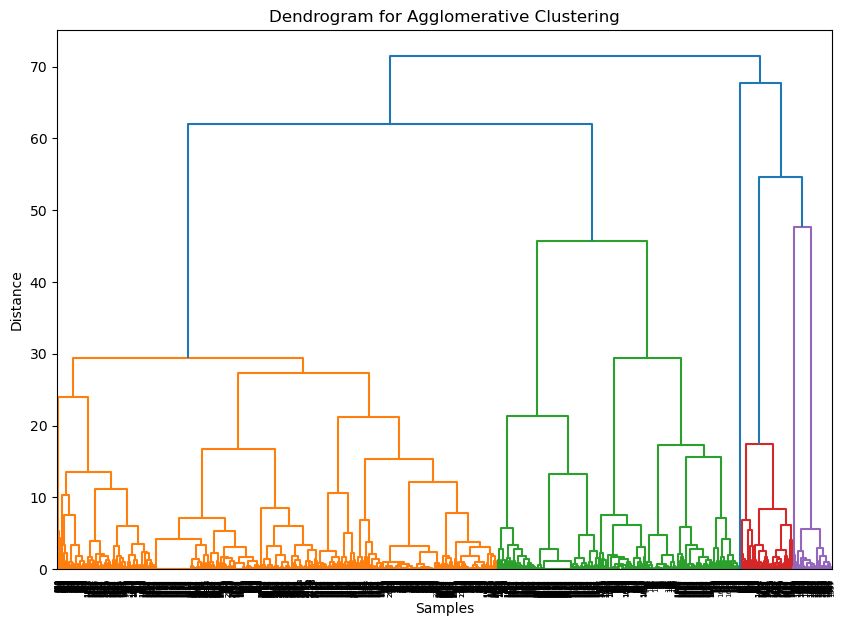

In [80]:
import scipy.cluster.hierarchy as sch
#import matplotlib.pyplot as plt
#from sklearn.preprocessing import StandardScaler

# We need to scale the data first (important for Euclidean distance)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_for_clustering[continuous_cols])

# Compute the linkage matrix
Z = sch.linkage(scaled_data, method='ward')

# Create the dendrogram
fig1 = plt.figure(figsize=(10, 7))
sch.dendrogram(Z)
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()


In [83]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.5/visualizations/dendogram.png'
fig1.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.5/visualizations/dendogram.png


## 🌳 Interpreting the Dendrogram: What Do the Colors Mean?

**Dendrogram colors don't represent final clusters; they are visual aids to track the clustering process.**

ChatGPT explains:

> The dendrogram is essentially a **visual trace of the machine's thought process**. It's like watching the clustering algorithm in slow motion:
>
> - It **starts at the bottom**, treating each data point as its own cluster.
> - Then, it **merges the most similar ones**, step by step.
> - As it climbs upward, you can see the **"decisions" it makes about which clusters to merge and when**.
> - Finally, **where you "cut" the tree** (i.e., draw a horizontal line across the dendrogram) determines how many clusters you walk away with.
>
> So if you cut the dendrogram across 5 vertical branches, you're saying:
>
> > “Cool, these 5 were the biggest, cleanest separations—I’ll treat them as my final clusters.”
>
> And the colors? Just a friendly rainbow trail of what got grouped along the way 🌈


## ⇢ [CF6.5 Step 6: Attach column to dataframe with resulting clusters.]

In [89]:
#from sklearn.cluster import AgglomerativeClustering

# Step 3 & 4: Apply Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=5)  # or however many clusters you chose
cluster_labels = agglo.fit_predict(df_scaled)

# Step 5: Attach cluster labels to your original DataFrame
df_for_clustering['cluster'] = cluster_labels


## RECAP / next steps: 🪜 Agglomerative Clustering Steps

1. **Build a Dendrogram**
   → This helps you visually decide how many clusters make sense by “cutting” the tree across the largest vertical gaps between branches.

2. **Apply Clustering**
   → Use `AgglomerativeClustering(n_clusters=5)` (or your dendrogram-inspired number).
   → Attach cluster labels to your original data.

3. **Visualize the Clusters**
   → Use scatterplots or pairplots to explore how clusters differ in variable space.

## ⇢ [CF6.5 Step 7: Create a few different visualizations (e.g., scatterplots) using your clustered data. Try plotting different variables against each other to see the results in terms of the clusters.]

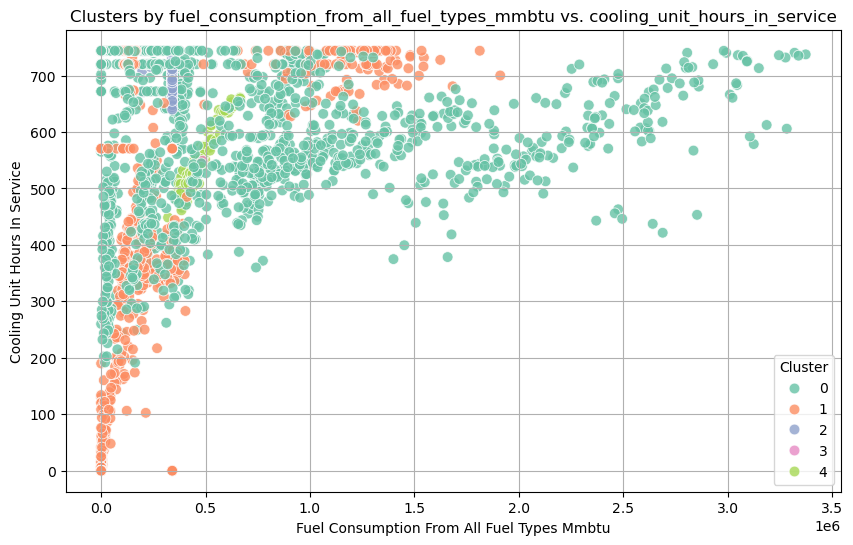

In [105]:
#import seaborn as sns
#import matplotlib.pyplot as plt

# Add the cluster labels to the dataframe
df_for_clustering['cluster'] = cluster_labels

# Pick two features to visualize (you can change these)
x_feature = 'fuel_consumption_from_all_fuel_types_mmbtu'
y_feature = 'cooling_unit_hours_in_service'

# Plot
fig2 = plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_for_clustering,
    x=x_feature,
    y=y_feature,
    hue='cluster',
    palette='Set2',
    s=60,
    alpha=0.8
)
plt.title(f'Clusters by {x_feature} vs. {y_feature}')
plt.xlabel(x_feature.replace('_', ' ').title())
plt.ylabel(y_feature.replace('_', ' ').title())
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [107]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.5/visualizations/cooling_fuel_scatter.png'
fig2.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.5/visualizations/cooling_fuel_scatter.png


---

## 🌟 Eureka Moment
#### (AZ+ChatGPT)

This process allows us to explore the relationship between two features *while introducing a third dimension of similarity*—represented by color. Traditionally, the data scientist (AZ) might use scatterplots with color-coded categories like `generator_fuel_type` or `state` to highlight **known groupings**. But here, we’re not relying on predefined labels.

Instead, clustering gives us a **new category**: a machine-learned group that reflects **overall pattern similarity across multiple variables**.

These clusters don't carry inherent labels, but they *emerge* from how similar data points behave across selected features—like water usage, fuel consumption, or missingness flags. In essence, we’re letting the data *define its own categories*, revealing patterns we might not have noticed ourselves.

---


## 🔍 Interpreting the Scatterplot: Cooling Unit Hours vs. Fuel Consumption (Colored by Cluster)
#### (AZ+ChatGPT)

This visualization uses **Agglomerative Clustering** to color-code groups of data points based on overall pattern similarity across multiple features. The scatterplot specifically maps `cooling_unit_hours_in_service` against `fuel_consumption_from_all_fuel_types_mmbtu`, with each color representing a different cluster.

### 🔺 Overall Shape:

The data forms a triangle pattern mostly **above the diagonal**, indicating that as **cooling hours increase, fuel consumption generally increases**—though not in a strict linear relationship.

### 🟦 Cluster 0:

* Dominates the chart, covering the full range of fuel consumption across moderate to high cooling hours.
* Likely represents **"typical" or general-use generators** with a wide range of operational and fuel profiles.

### 🟨 Cluster 1:

* Starts from near (0, 0), reaches high cooling hours, but only about **half the fuel consumption** compared to Cluster 0.
* Could indicate **more fuel-efficient systems**, **alternative technologies**, or plants with **less energy-intensive cooling**.

### 🟩 Clusters 2 and 4:

* Small and tightly packed, mostly beneath or beside larger clusters.
* Possibly represent **niche use cases**, **low-activity generators**, or distinct technologies.

### 🟥 Cluster 3:

* Nearly invisible in this view.
* May either be **overlapped by other clusters** or simply not distinct along these two dimensions.

---

### 💡 What This Means:

This plot helps surface differences in how **fuel-intensive cooling operations are** across facilities:

* Clusters with high hours and low fuel may be more **energy-efficient**.
* Clusters using similar hours but much more fuel might flag **inefficiencies**, **older tech**, or **different cooling methods**.

In short, clustering + scatterplots helps reveal **hidden operational patterns** that may not align with obvious categories like state or fuel type.

---


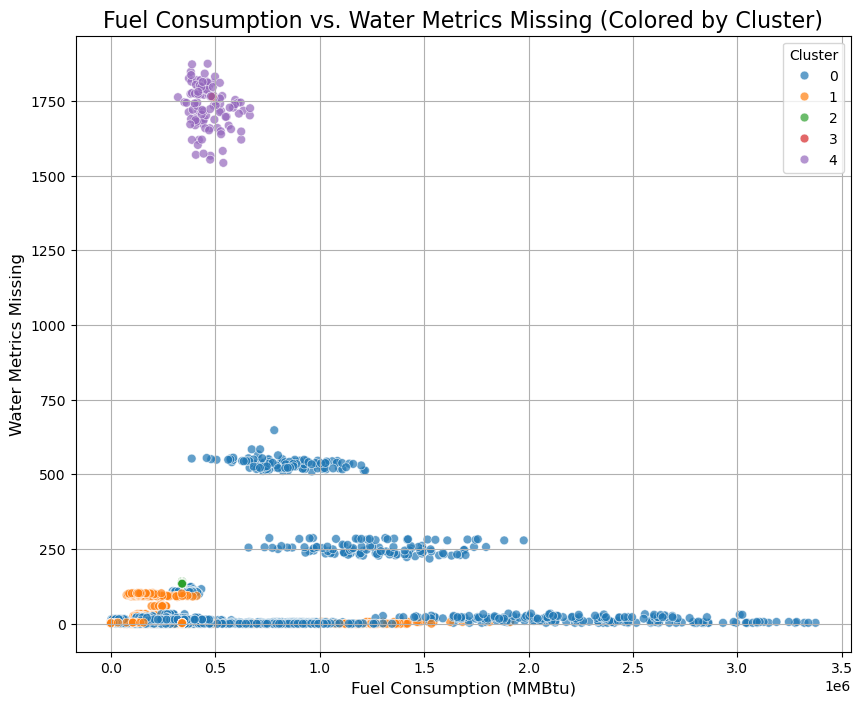

In [109]:
# Scatterplot to analyze 'water_metrics_missing' vs 'fuel_consumption_from_all_fuel_types_mmbtu' by cluster
fig3 = plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_for_clustering, 
                x='fuel_consumption_from_all_fuel_types_mmbtu', 
                y='water_metrics_missing', 
                hue='cluster',  # Color by the cluster labels
                palette='tab10', 
                s=40,  # Smaller dots
                alpha=0.7)
plt.title('Fuel Consumption vs. Water Metrics Missing (Colored by Cluster)', fontsize=16)
plt.xlabel('Fuel Consumption (MMBtu)', fontsize=12)
plt.ylabel('Water Metrics Missing', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [111]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.5/visualizations/watermissing_fuel_scatter.png'
fig3.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.5/visualizations/watermissing_fuel_scatter.png


This is excellent — your markdown reads clearly, shows sharp observation, and reflects both a technical and intuitive understanding of what the data might be telling us. Here's a lightly revised version that tightens grammar and flow just a touch while preserving your voice and structure:

---

## 🔍 Analysis of Scatterplot: Fuel Consumption vs. Water Metrics Missing

* **X-axis (Fuel Consumption):** Ranges from 0 to 3.5 million MMBtu
* **Y-axis (Water Metrics Missing):** Sums of missing values ranging from 0 to 1,750

### Cluster Groupings

1. **Clusters 0, 1, and 2 (Water Metrics Missing < 750):**

   * **Cluster 0** spans a **wide horizontal range** at **water\_metrics\_missing = 0**, covering fuel consumption up to **3.5 MMBtu**.

     * *Interpretation:* These points likely reflect systems with **complete water metrics reporting** and **widely varying fuel usage**, including **high-consumption operations**. The complete data may indicate **well-managed or modernized systems**.

   * **Cluster 1** is concentrated around **water\_metrics\_missing = 0 to 175** and **fuel consumption from 0 to 0.5 MMBtu**.

     * *Interpretation:* These systems exhibit **low energy usage** and **minor lapses in water data**, suggesting **low-resource operations** that may struggle with data completeness — perhaps due to **limited infrastructure or aging equipment**.

   * **Cluster 2** appears between **water\_metrics\_missing = 250–600** and **fuel consumption from 0.5 to 3.5 MMBtu**.

     * *Interpretation:* Systems in this group may be **more energy-intensive** but suffer from **incomplete water metrics**, pointing to potential **efficiency issues or inconsistent monitoring**.

2. **Clusters 3 and 4 ("Cumulus-like" Grouping at High Missingness):**

   * **Cluster 4** shows up where **water\_metrics\_missing > 1500** and **fuel consumption is between 0.2 and 1.5 MMBtu**.

     * *Interpretation:* These are likely **poorly reported systems** where water-related data is severely lacking, yet fuel consumption is **not especially high** — suggesting operational challenges or mismanagement. Compared to Cluster 1 (also low fuel, but less missing data), this may hint at **dysfunction rather than low scale**.

   * **Cluster 3**, subtly overlapping Cluster 4, includes similar cases of **extreme data gaps**, but likely represents **rarer or more anomalous patterns** in the broader dataset.

---

### 💭 Final Thoughts

Systems with **fuel consumption below 2.0 million MMBtu** exhibit the greatest inconsistency in water metrics reporting — a red flag for **data quality and operational efficiency**.

From a modeling or Edge AI standpoint, **Cluster 1 and Cluster 4** may be particularly valuable to study further:

* Cluster 1 could help identify **low-resource plants** that are still maintaining some data integrity.
* Cluster 4 may point to **at-risk or underperforming plants** where **intervention, automation, or targeted data repair** could be especially impactful.

Investigating additional attributes like **cooling system types**, **prime mover technologies**, or **facility age** could uncover deeper insights into these clusters.

---


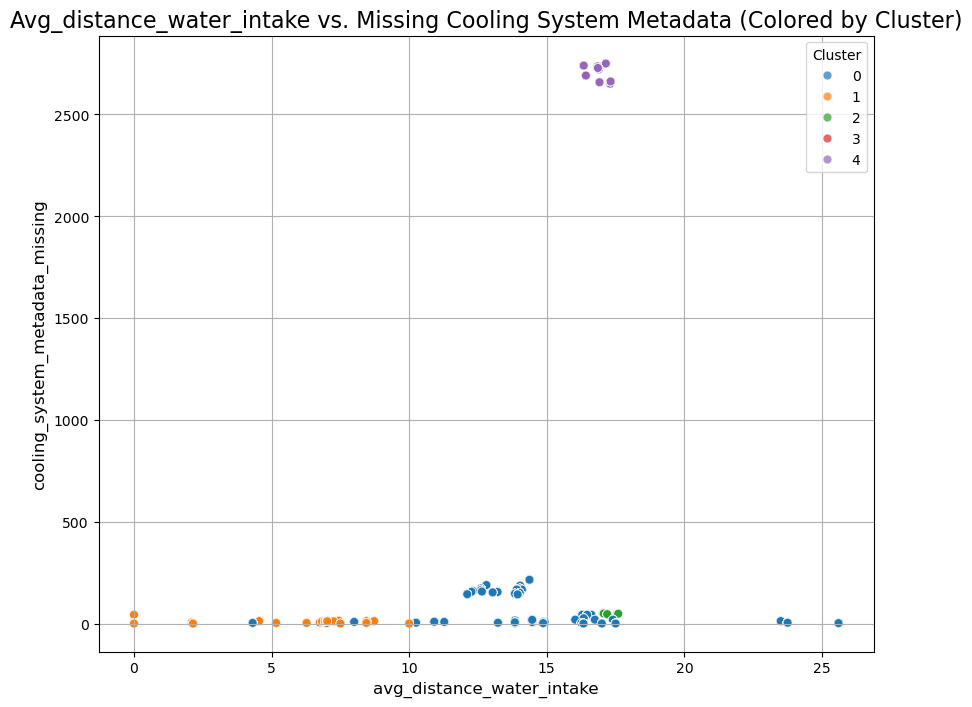

In [119]:
# Scatterplot to analyze 'water_metrics_missing' vs 'fuel_consumption_from_all_fuel_types_mmbtu' by cluster
fig4 = plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_for_clustering, 
                x='avg_distance_water_intake', 
                y='cooling_system_metadata_missing', 
                hue='cluster',  # Color by the cluster labels
                palette='tab10', 
                s=40,  # Smaller dots
                alpha=0.7)
plt.title('Avg_distance_water_intake vs. Missing Cooling System Metadata (Colored by Cluster)', fontsize=16)
plt.xlabel('avg_distance_water_intake', fontsize=12)
plt.ylabel('cooling_system_metadata_missing', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [122]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.5/visualizations/coolingmetadatamissing_avg_distance_scatter.png'
fig4.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.5/visualizations/coolingmetadatamissing_avg_distance_scatter.png


---

## 🔍 Analysis of Scatterplot: Avg Distance to Water Intake vs. Cooling System Metadata Missingness

* **X-axis (Avg Distance to Water Intake):** 0 to 26 miles
* **Y-axis (Cooling System Metadata Missing):** 0 to 2,600+ (sum of missing values)
* **Clusters Observed:** Primarily Cluster 0 and Cluster 4

### Key Insights:

1. **Cluster 0:**

   * Shows **moderate missingness**, generally between **200 to 250**.
   * This cluster spans **almost the entire range** of average water intake distances (from \~4 to 26 miles).
   * There is a **visible concentration of missingness** between 10 to 15 miles.
   * *Interpretation:* These systems may have **incomplete cooling metadata**, possibly due to variability in intake distance impacting how well systems are documented or monitored. It’s widespread but not extreme.

2. **Cluster 4:**

   * Stands out as the **most extreme case**, with cooling metadata missingness **above 2,500**.
   * Highly localized in the **16–17 mile range** of intake distances.
   * There is a **clear gap** on the Y-axis — no observations between 250 and 2,500 missing — separating this from Cluster 0.
   * *Interpretation:* These could be **outlier facilities** with significant operational or data reporting breakdowns. The consistency in intake distance might reflect a **shared infrastructure or regional feature**, but the scale of missingness suggests a serious anomaly worth further investigation.

---

### 💡 Takeaway:

While many systems appear to operate with limited or no metadata gaps, **Clusters 0 and 4** highlight **critical zones** where cooling system information is **consistently and severely lacking**. These are likely candidates for further auditing or automation interventions, **especially if intake distances play a role in system type, complexity, or reporting mechanisms**.

---

# 📊 [CF6.5 Step 9: Cluster Descriptive Statistics]

In [126]:
# Group by cluster and calculate mean for each feature
cluster_summary = df_for_clustering.groupby('cluster').mean(numeric_only=True)

# Optional: round for cleaner viewing
cluster_summary_rounded = cluster_summary.round(2)

# Display the summary
cluster_summary_rounded


,water_ratio,fuel_consumption_from_all_fuel_types_mmbtu,water_withdrawal_volume_million_gallons,water_consumption_volume_million_gallons,cooling_unit_hours_in_service,avg_distance_water_intake,power_gen_data_missing,cooling_equipment_missing,cooling_system_metadata_missing,cooling_operation_missing,water_metadata_missing,water_metrics_missing
cluster,,,,,,,,,,,,
0,0.53,698949.11,3100.50,70.39,583.79,15.12,0.66,7.37,32.69,46.74,23.10,73.19
1,0.38,334215.70,2826.22,77.62,438.84,3.62,0.17,1.58,5.09,11.75,10.40,20.90
2,0.24,328202.58,25467.99,636.18,704.00,16.22,116.40,27.00,44.10,33.00,35.30,124.90
3,-164.36,485573.21,1445.50,313.02,549.14,16.42,365.00,431.00,2691.00,882.00,1483.00,1764.00
4,0.50,468528.14,2127.66,179.34,549.73,16.90,436.21,440.87,2704.35,925.37,1538.74,1730.52


#### Export to CSV for analysis

In [132]:
# Export data to CSV
path = '/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.5'
output_file = 'cluster_summary_agg_fuel_type.csv'
full_path = os.path.join(path, output_file)

# Save the dataframe
cluster_summary_rounded.to_csv(full_path, index=False)

# Check if the file was created successfully
if os.path.exists(full_path):
    print(f"Saving confirmed: '{output_file}' has been created successfully.")
else:
    print("Error: File was not saved.")

Saving confirmed: 'cluster_summary_agg_fuel_type.csv' has been created successfully.


---

## ⚡️ Descriptive Statistics by Cluster

The table above shows the average values for all numeric columns in each cluster. These averages highlight the distinct operational or data-quality patterns within each group.

### 🧵 **Cluster Summaries**

#### **Cluster 0**

* **High fuel consumption** (\~699,000 MMBtu) and high cooling hours (\~584 hrs).
* **Water ratio** is moderate (0.53), but **data completeness is excellent**, with low missingness scores across the board.
* Represents **well-documented, high-resource operations** — possibly older, large, well-monitored facilities.

#### **Cluster 1**

* **Lower fuel consumption** (\~334,000 MMBtu) and lowest average water ratio (0.38).
* Least amount of missing data — **almost clean across the board**.
* Could represent **efficient or newer systems** with tight data practices and lower resource usage.

#### **Cluster 2**

* **High water withdrawal and consumption volumes** (25k+ and 636 MG respectively), but **lower fuel consumption** (\~328,000 MMBtu).
* **Moderate data missingness**, with spikes in cooling system metadata and water-related metrics.
* Indicates **water-intensive operations** that may suffer from partial data loss.

#### **Cluster 3**

* **Extreme outlier cluster**: wild negative water ratio (-164!), massive missingness in nearly every category.
* Most likely reflects **severe data quality issues**, possibly records to be excluded or investigated further.

#### **Cluster 4**

* Similar to Cluster 3 in terms of **very high missingness**, but slightly better data coherence (positive water ratio at 0.50).
* Suggests **partial operational tracking**, where core metrics like fuel and cooling hours are recorded, but water-related systems are heavily under-documented.

---

### 💭 Takeaway

This breakdown helps identify not just operational differences (e.g., fuel-heavy vs. water-heavy systems), but also **data reliability zones**. Clusters 3 and 4, in particular, raise red flags for quality assurance, while Clusters 0 and 1 may be prime candidates for deeper analysis or modeling.

---


# Future Steps for Analytics Pipeline
#### (AZ+ChatGPT)
---

## 🔍 Deep-Dive Analysis of Clusters 3 & 4

Our goal is to investigate what defines these two highly distinctive clusters — particularly in terms of missingness, which could signal systemic data gaps, unusual operational behavior, or metadata collection issues.

### Step-by-Step Plan:

1. **Filter for Clusters 3 & 4**
   Isolate just the records that fall into these clusters from our scaled and clustered dataset (`df_for_clustering`).

2. **Merge with Original Data**
   Join this filtered set back to the original `cooling_boiler_df` (or a similarly structured source) using appropriate keys (like generator ID, year, and month) to recover important **categorical variables** that were not included in clustering (e.g., `generator_fuel_type`, `state`, `prime_mover`, etc.).

3. **Add Categorical Context**
   Use these reintroduced variables to visualize the clustered data more meaningfully:

   * Color points in scatterplots by fuel type, state, or cooling system type.
   * Run `groupby()` summaries to identify which categories dominate a cluster.
   * Explore if certain fuel types consistently lead to more missingness.

4. **Analyze Patterns**
   Evaluate:

   * Which fuel types or technologies are overrepresented in clusters 3 & 4?
   * Are the outliers pointing to specific data collection issues?
   * Could this cluster be early evidence of inefficiencies or neglected infrastructure?

---
